# Redes neurais - Impressão digital

# Database
Execução da rede neural fornecida utilizando a base de dados com melhores resultados na primeira fase do projeto - Set2 300px.

In [1]:
!pip install -q torch_snippets

In [2]:
from torch_snippets import *
import torch
import os
from torchvision import transforms, models

device = 'cuda' if torch.cuda.is_available() else 'cpu' # colab offers limited gpu acess

In [3]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, image_folder, imagenames_file, transform=None):
        self.image_folder    = image_folder
        self.imagenames_file = imagenames_file
        self.nitems          = 0
        self.transform       = transform

        f     = open(self.imagenames_file,"r")
        self.pairs = []
        for line in f:
            pair = line.strip().split(" ")
            self.pairs.append(pair)

        self.nitems = len(self.pairs)

    def __getitem__(self, ix):
        image1      = self.pairs[ix][0]
        image2      = self.pairs[ix][1]
        
        person1 = image1.split("_")[0] # 001_01.png -> 001
        person2 = image2.split("_")[0] # 002_01.png -> 002
        
        if (person1 == person2):
            truelabel = 0
        else:
            truelabel = 1
        
        image1 = read("{}/{}".format(self.image_folder,image1))
        image2 = read("{}/{}".format(self.image_folder,image2))
        
        image1 = np.expand_dims(image1, 2)
        image2 = np.expand_dims(image2, 2)
        
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
            
        return image1, image2, np.array([truelabel])
    
    def __len__(self):
        return self.nitems

In [4]:
from torchvision.transforms.transforms import ToPILImage
# Regular preprocessing transformation. After being resized, 
# it is converted into a tensor for normalization.

# Such transformations are applied everytime images are loaded from the filename lists in training, validation, 
# and test sets. We will do that during training, then by adding affine transformations and increasing the number 
# of epochs, we are actually implementing data augmentation. 

prep = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomAffine(5, (0.01,0.2), scale=(0.9,1.1)),
    transforms.Resize((100,100)),
    transforms.ToTensor()
    # transforms.Normalize((0.5), (0.5))
])

prepVGG = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomAffine(5, (0.01,0.2), scale=(0.9,1.1)),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) ),
    # transforms.Normalize((0.5), (0.5))
])

aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((300,300), interpolation=transforms.InterpolationMode.BILINEAR, max_size=None, antialias=True),
    transforms.RandomAffine(degrees=15, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2), interpolation=transforms.InterpolationMode.BILINEAR, fill=0, fillcolor=None, resample=None),
    transforms.CenterCrop(250),
    transforms.Resize((100,100), interpolation=transforms.InterpolationMode.BILINEAR, max_size=None, antialias=True),
    transforms.ToTensor()
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

In [5]:
import random
with open("compare_set2_300.txt", 'r') as fp:
    data = [(random.random(), line) for line in fp]
    dataset_size = len(data)
    train_perc = 0.75
    valid_perc = 0.25
    num_train_samples = int(dataset_size*train_perc)
    num_valid_samples = int(dataset_size*valid_perc)
    
data.sort()

with open("train_comparisons.txt", 'w') as train:
    for _, line in data[:num_train_samples]:
        train.write(line)

with open("valid_comparisons.txt", 'w') as valid:
    for _, line in data[:num_valid_samples]:
        valid.write(line)

In [6]:
image_folder = "./p2_registered_2_300" # folder with images of a dataset
train_imagenames_file = "./train_comparisons.txt" # csv file with image comparisons for training
valid_imagenames_file = "./valid_comparisons.txt" # csv file with image comparisons for validation

# criação do objeto da classe dataset
dataset = SiameseNetworkDataset(image_folder=image_folder, imagenames_file = train_imagenames_file, transform=aug)

# Set 1
## Rede neural
Rede Siamesa

In [7]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Conv2d(ni, no, kernel_size=3, padding=1, bias=False), #, padding_mode='reflect'),
        nn.BatchNorm2d(no),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.features = nn.Sequential(
            convBlock(1,16),
            convBlock(16,128),
            nn.Flatten(),
            nn.Linear(128*25*25, 512), nn.ReLU(inplace=True),
            nn.Linear(512, 256), nn.ReLU(inplace=True),
            nn.Linear(256, 64)
        )

    def forward(self, input1, input2):
        output1 = self.features(input1)
        output2 = self.features(input2)
        return output1, output2

In [9]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2)/2 + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))/2
        acc = ((euclidean_distance > contrastive_thres) == label).float().mean()
        return loss_contrastive, acc

def train_batch(model, data, optimizer, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    optimizer.zero_grad()
    codesA, codesB = model(imgsA, imgsB)
    loss, acc = criterion(codesA, codesB, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

def valid_batch(model, data, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]

    model.eval() # put the model in evaluation mode
    codesA, codesB = model(imgsA, imgsB) # predict the output for the batch
    loss, acc  = criterion(codesA, codesB, labels) # compute loss, both inputs must have the same sizes
    model.train()
    
    return loss.item(), acc.item()

## Set1 - Treino da Rede

In [10]:
batchsize = 1 # defina um batch maior quando tiver mais imagens

def GetBatches(image_folder, image_names, batchsize, transformation):
    datatensor = SiameseNetworkDataset(image_folder, image_names, transformation) 
    dataloader = DataLoader(datatensor, batch_size=batchsize, shuffle=True)
    return(dataloader)

# as transformations, you may choose None, prep, or aug. However, aug applies to the training set only
trainload = GetBatches(image_folder, train_imagenames_file, batchsize, aug)  
validload = GetBatches(image_folder, valid_imagenames_file, batchsize, prep)

print("Quantidade de batches de treino: ", len(trainload))
print("Quantidade de batches de validação: ", len(validload))

Quantidade de batches de treino:  8
Quantidade de batches de validação:  3


In [11]:
inspect(next(iter(trainload))) # inspect a couple of items in the batches

list of 3 items
	Tensor	Shape: torch.Size([1, 1, 100, 100])	Min: 0.000	Max: 1.000	Mean: 0.698	dtype: torch.float32 @ cpu
	Tensor	Shape: torch.Size([1, 1, 100, 100])	Min: 0.000	Max: 1.000	Mean: 0.726	dtype: torch.float32 @ cpu
	Tensor	Shape: torch.Size([1, 1])	Min: 0.000	Max: 0.000	Mean: 0.000	dtype: torch.int64 @ cpu


In [33]:
model      = SiameseNetwork().to(device)

criterion  = ContrastiveLoss()
optimizer  = optim.Adam(model.parameters(),lr = 0.001, weight_decay=0.01)
nepochs    = 10 # default training value was 200, but requires a lot of time

contrastive_thres = 12

EPOCH: 10.000	val_loss: 0.000	val_acc: 1.000	(41.68s - 0.00s remaining)))

100%|██████████| 111/111 [00:00<00:00, 11905.89it/s]


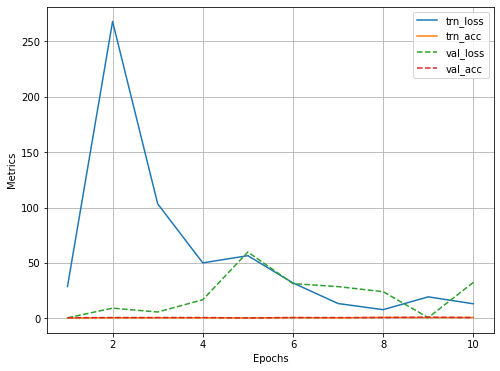

In [34]:
log = Report(nepochs)

for epoch in range(nepochs):
    N = len(trainload)
    for i, data in enumerate(trainload):
        batch_loss, batch_acc = train_batch(model, data, optimizer, criterion)
        log.record(epoch+(1+i)/N, trn_loss=batch_loss, trn_acc=batch_acc, end='\r')

    N = len(validload)
    with torch.no_grad():
        for i, data in enumerate(validload):
            batch_loss, batch_acc = valid_batch(model, data, criterion)
            log.record(epoch+(1+i)/N, val_loss=batch_loss, val_acc=batch_acc, end='\r')  
            
log.plot_epochs() 

In [35]:
torch.save(model.state_dict(), "model_set1.pth")

## Set1 - Avaliação do Modelo

In [36]:
# Se já possui um modelo treinado, carregue os pesos
model_path = './model_set1.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

SiameseNetwork(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=80000, out_features=512, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=256, out_features=64, bias=True)
  )
)

In [37]:
test_image_folder = "./p2_test"  
test_imagenames_file = "./compare_test.txt" # mude para o arquivo de teste
testload = GetBatches(test_image_folder, test_imagenames_file, batchsize, prep)
inspect(next(iter(testload)))

list of 3 items
	Tensor	Shape: torch.Size([1, 1, 100, 100])	Min: 0.063	Max: 1.000	Mean: 0.617	dtype: torch.float32 @ cpu
	Tensor	Shape: torch.Size([1, 1, 100, 100])	Min: 0.027	Max: 1.000	Mean: 0.599	dtype: torch.float32 @ cpu
	Tensor	Shape: torch.Size([1, 1])	Min: 0.000	Max: 0.000	Mean: 0.000	dtype: torch.int64 @ cpu


In [38]:
#put model in evaluation mode
model.eval()

Acc = []
Loss = []
Labels = []

#process all batches
for ix, data in enumerate(testload):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    
    with torch.no_grad():
        codesA, codesB = model(imgsA, imgsB)

        loss, acc = criterion(codesA, codesB, labels)
        Labels.append(labels)
        Acc.append(acc.detach().cpu().numpy())
        Loss.append(loss.detach().cpu().numpy())

print('Acurácia no conjunto de teste: {:.6f}'.format(np.mean(Acc)))
print('Loss no conjunto de teste: {:.6f}'.format(np.mean(Loss)))

Acurácia no conjunto de teste: 0.666667
Loss no conjunto de teste: 4.353353


In [30]:
# Distance histogram
different = []
same = []
model.eval()

image_folder = './p2_test'
imagenames_file = './compare_test.txt'

dataset       = SiameseNetworkDataset(image_folder=image_folder, imagenames_file = imagenames_file, transform=prep)

dataloader    = DataLoader(dataset,batch_size=1,shuffle=True)

for ix, data in enumerate(dataloader):
    if (ix + 1)%1000 == 0:
        print('Processing batch {}/{}'.format((ix + 1), len(dataloader)))
        imgsA, imgsB, labels = [t.to(device) for t in data]
        codesA, codesB       = model(imgsA, imgsB)

    with torch.no_grad():
        euclidean_distance = F.pairwise_distance(codesA, codesB)
        
        if (labels == 0): # same person
            same.append(euclidean_distance.item())
        else:
            different.append(euclidean_distance.item())

[]

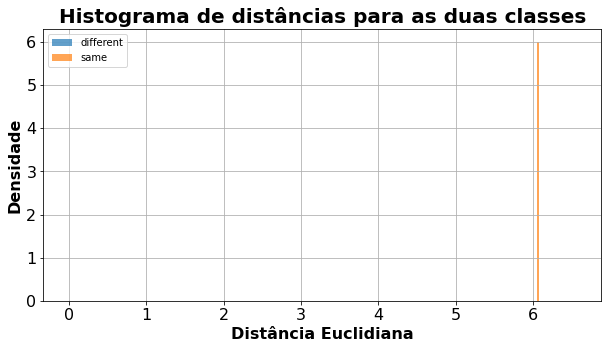

In [31]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (10,5))
ax.set_title('Histograma de distâncias para as duas classes', fontsize = 20, fontweight = 'bold')
ax.set_xlabel('Distância Euclidiana', fontsize = 16, fontweight = 'bold')
ax.set_ylabel('Densidade', fontsize = 16, fontweight = 'bold')
ax.hist(different,bins = 50, alpha = 0.7, label = 'different')
ax.hist(same, bins = 50, alpha = 0.7, label = 'same')
ax.tick_params(labelsize = 16, axis = 'both')
ax.legend()
ax.grid(True)
plt.plot()

## Set1 - Deploy

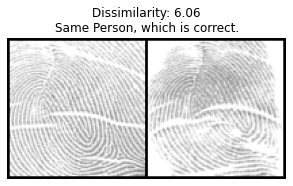

Type y to continue: y


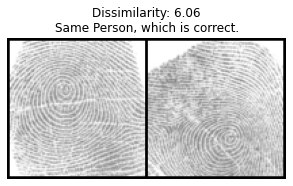

Type y to continue: y


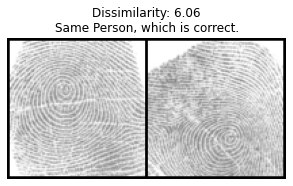

Type y to continue: y


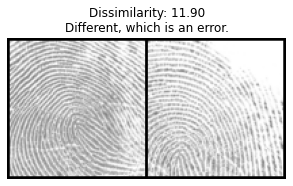

Type y to continue: n


In [32]:
model.eval()
do_comparison = 'y'

image_folder = './p2_test'
imagenames_file = './compare_test.txt'

dataset       = SiameseNetworkDataset(image_folder=image_folder, imagenames_file = imagenames_file, transform=prep)

dataloader    = DataLoader(dataset,batch_size=1,shuffle=True)

while(do_comparison=='y'):
    dataiter                  = iter(dataloader)
    image1, image2, truelabel = [t.to(device) for t in next(dataiter)]
    concatenated              = torch.cat((image1*0.5+0.5, image2*0.5+0.5),0)

    output1,output2           = model(image1,image2)
    euclidean_distance        = F.pairwise_distance(output1, output2)
    if (euclidean_distance.item() <= contrastive_thres):
        if (truelabel != 0):
            output = 'Same Person, which is an error.'
        else:
            output = 'Same Person, which is correct.'
    else:
        if (truelabel == 0):
            output = 'Different, which is an error.'
        else:
            output = 'Different, which is correct.'
    
    show(torchvision.utils.make_grid(concatenated),
         title='Dissimilarity: {:.2f}\n{}'.format(euclidean_distance.item(), output))
    plt.show()
    do_comparison = input("Type y to continue: ")

# Set 2
## Rede neural
Rede Siamesa com VGG Backbone

In [47]:
class SiameseNetworkVGGBackbone(nn.Module):
    def __init__(self):
        super(SiameseNetworkVGGBackbone, self).__init__()
        self.features = nn.Sequential(*list(models.vgg16(pretrained=True).children())[:-1])
        for param in self.features.parameters():
            param.requires_grad = False
      
        self.dimensionality_reductor = nn.Sequential(
            nn.Flatten(),
            models.vgg16(pretrained=True).classifier[0],
            nn.Linear(4096, 512), nn.ReLU(inplace = True),
            nn.Linear(512, 256), nn.ReLU(inplace=True),
            nn.Linear(256, 64)
        )


    def forward(self, input1, input2):
        output1 = self.features(input1)
        output1 = self.dimensionality_reductor(output1)
        output2 = self.features(input2)
        output2 = self.dimensionality_reductor(output2)

        return output1, output2

## Set2 - Treino da rede

In [48]:
batchsize = 1 # defina um batch maior quando tiver mais imagens

image_folder = './p2_registered_2_300'
imagenames_file = './compare_set2_300.txt'

def GetBatches(image_folder, image_names, batchsize, transformation):
    datatensor = SiameseNetworkDataset(image_folder, image_names, transformation) 
    dataloader = DataLoader(datatensor, batch_size=batchsize, shuffle=True)
    return(dataloader)

# as transformations, you may choose None, prep, or aug. However, aug applies to the training set only
trainload = GetBatches(image_folder, train_imagenames_file, batchsize, prepVGG)
validload = GetBatches(image_folder, valid_imagenames_file, batchsize, prepVGG)

print("Quantidade de batches de treino: ", len(trainload))
print("Quantidade de batches de validação: ", len(validload))

Quantidade de batches de treino:  8
Quantidade de batches de validação:  3


In [49]:
inspect(next(iter(trainload))) # inspect a couple of items in the batches

list of 3 items
	Tensor	Shape: torch.Size([1, 3, 224, 224])	Min: 0.000	Max: 1.000	Mean: 0.599	dtype: torch.float32 @ cpu
	Tensor	Shape: torch.Size([1, 3, 224, 224])	Min: 0.004	Max: 1.000	Mean: 0.578	dtype: torch.float32 @ cpu
	Tensor	Shape: torch.Size([1, 1])	Min: 0.000	Max: 0.000	Mean: 0.000	dtype: torch.int64 @ cpu


In [50]:
model      = SiameseNetworkVGGBackbone().to(device)

criterion  = ContrastiveLoss()
optimizer  = optim.Adam(model.parameters(),lr = 0.001, weight_decay=0.01)
nepochs    = 5 # default training value was 200, but requires a lot of time

contrastive_thres = 5

EPOCH: 5.000	val_loss: 6.921	val_acc: 0.000	(58.55s - 0.00s remaining)g)))

100%|██████████| 106/106 [00:00<00:00, 22124.72it/s]


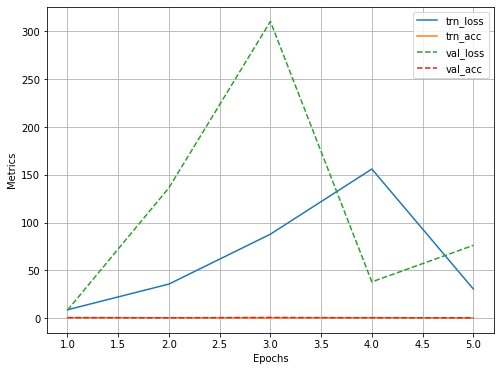

In [51]:
log = Report(nepochs)

for epoch in range(nepochs):
    N = len(trainload)
    for i, data in enumerate(trainload):
        batch_loss, batch_acc = train_batch(model, data, optimizer, criterion)
        log.record(epoch+(1+i)/N, trn_loss=batch_loss, trn_acc=batch_acc, end='\r')

    N = len(validload)
    with torch.no_grad():
        for i, data in enumerate(validload):
            batch_loss, batch_acc = valid_batch(model, data, criterion)
            log.record(epoch+(1+i)/N, val_loss=batch_loss, val_acc=batch_acc, end='\r')  
            
log.plot_epochs() 

In [52]:
torch.save(model.state_dict(), "model_set2.pth")

## Set2 - Avaliação do Modelo

In [53]:
# Se já possui um modelo treinado, carregue os pesos
model_path = './model_set2.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

SiameseNetworkVGGBackbone(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inpla

In [56]:
test_image_folder = "./p2_registered_2_300"  
test_imagenames_file = "./compare_set2_300.txt" # mude para o arquivo de teste
testload = GetBatches(test_image_folder, test_imagenames_file, batchsize, prep)
inspect(next(iter(testload)))

list of 3 items
	Tensor	Shape: torch.Size([1, 1, 100, 100])	Min: 0.008	Max: 1.000	Mean: 0.473	dtype: torch.float32 @ cpu
	Tensor	Shape: torch.Size([1, 1, 100, 100])	Min: 0.082	Max: 0.996	Mean: 0.584	dtype: torch.float32 @ cpu
	Tensor	Shape: torch.Size([1, 1])	Min: 0.000	Max: 0.000	Mean: 0.000	dtype: torch.int64 @ cpu


In [57]:
#put model in evaluation mode
model.eval()

Acc = []
Loss = []

#process all batches
for ix, data in enumerate(testload):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    
    with torch.no_grad():
        codesA, codesB = model(imgsA, imgsB)

        loss, acc = criterion(codesA, codesB, labels)
        Acc.append(acc.detach().cpu().numpy())
        Loss.append(loss.detach().cpu().numpy())

print('Acurácia no conjunto de teste: {:.6f}'.format(np.mean(Acc)))
print('Loss no conjunto de teste: {:.6f}'.format(np.mean(Loss)))

RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[1, 1, 100, 100] to have 3 channels, but got 1 channels instead

In [58]:
# Distance histogram
different = []
same = []
model.eval()

image_folder = './p2_registered_2_300'
imagenames_file = './compare_set2_300.txt'

dataset = SiameseNetworkDataset(image_folder=image_folder, imagenames_file = imagenames_file, transform=prep)

dataloader = DataLoader(dataset,batch_size=1,shuffle=True)

for ix, data in enumerate(dataloader):
    if (ix + 1)%1000 == 0:
        print('Processing batch {}/{}'.format((ix + 1), len(dataloader)))
        
    imgsA, imgsB, labels = [t.to(device) for t in data]
    codesA, codesB       = model(imgsA, imgsB)

    with torch.no_grad():
        euclidean_distance = F.pairwise_distance(codesA, codesB)
        
    if (labels == 0): # same person
        same.append(euclidean_distance.item())
        
    else:
        different.append(euclidean_distance.item())

RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[1, 1, 100, 100] to have 3 channels, but got 1 channels instead

[]

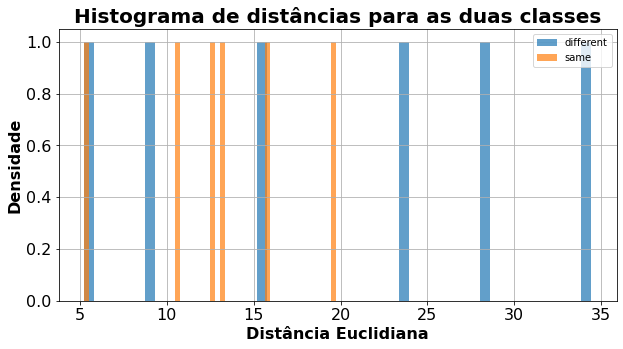

In [23]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (10,5))
ax.set_title('Histograma de distâncias para as duas classes', fontsize = 20, fontweight = 'bold')
ax.set_xlabel('Distância Euclidiana', fontsize = 16, fontweight = 'bold')
ax.set_ylabel('Densidade', fontsize = 16, fontweight = 'bold')
ax.hist(different,bins = 50, alpha = 0.7, label = 'different')
ax.hist(same, bins = 50, alpha = 0.7, label = 'same')
ax.tick_params(labelsize = 16, axis = 'both')
ax.legend()
ax.grid(True)
plt.plot()

## Set2 - Deploy

In [59]:
model.eval()
do_comparison = 'y'

image_folder = './p2_registered_2_300'
imagenames_file = './compare_set2_300.txt'

dataset       = SiameseNetworkDataset(image_folder=image_folder, imagenames_file = imagenames_file, transform=prep)

dataloader    = DataLoader(dataset,batch_size=1,shuffle=True)

while(do_comparison=='y'):
    dataiter                  = iter(dataloader)
    image1, image2, truelabel = [t.to(device) for t in next(dataiter)]
    concatenated              = torch.cat((image1*0.5+0.5, image2*0.5+0.5),0)

    output1,output2           = model(image1,image2)
    euclidean_distance        = F.pairwise_distance(output1, output2)
    if (euclidean_distance.item() <= contrastive_thres):
        if (truelabel != 0):
            output = 'Same Person, which is an error.'
        else:
            output = 'Same Person, which is correct.'
    else:
        if (truelabel == 0):
            output = 'Different, which is an error.'
        else:
            output = 'Different, which is correct.'
    
    show(torchvision.utils.make_grid(concatenated),
         title='Dissimilarity: {:.2f}\n{}'.format(euclidean_distance.item(), output))
    plt.show()
    do_comparison = input("Type y to continue: ")

RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[1, 1, 100, 100] to have 3 channels, but got 1 channels instead